# Calendar Spread Payoff

A calendar spread strategy profits from the time decay and/or increase in the implied volatility of the options. In this notebook, we will create a payoff graph of calendar spread at the expiry of front-month option.

## Importing The Libraries

In [3]:
# Data manipulation
import numpy as np
import pandas as pd

# To plot
import matplotlib.pyplot as plt
import seaborn

# BS Model
import mibian

## Setup Of A Calendar Spread Strategy
Calendar spread involves options of the same underlying asset, the same strike price but with different expiration dates. 

- If a Call or Put is Sold with near-term expiration it is called "<font color=blue>“front-month”</font>"
- If a Call or Put is Bought with long-term expiration it is called "<font color=blue>“back-month”</font>"

## Calendar Spread On Nifty
We will setup the Calendar Spread on Nifty as shown below at the same Strike Price

- Sell 11000 strike call @ INR 85.20 expiring on 27 July 2018 — <font color=blue>“front-month”</font>
- Buy 11000 strike call @ INR 201.70 expiring on 30 August 2018 — <font color=blue>“back-month”</font>

In [4]:
# Nifty futures price
nifty_jul_fut = 11030.50
nifty_aug_fut = 11046.40

strike_price = 11000
jul_call_price = 85.20
aug_call_price = 201.70
setup_cost = aug_call_price - jul_call_price

# Today's date is 20 July 2018. Therefore, days to July expiry is 7 days and days to August expiry is 41 days.
days_to_expiry_jul_call = 7
days_to_expiry_aug_call = 41

# Range of values for Nifty
sT = np.arange(0.92*nifty_jul_fut, 1.1*nifty_aug_fut, 1)

# interest rate for input to Black-Scholes model
interest_rate = 0.0

## Implied Volatility (IV)

We calculate the IV using Black Scholes model for the front-month and back-month call option.
To calculate the call price for different values of Nifty, this IV will be used later as an input to Black-Scholes model.

In [5]:
# Front-month IV
jul_call_iv = mibian.BS([nifty_jul_fut, strike_price, interest_rate, days_to_expiry_jul_call],
                        callPrice=jul_call_price).impliedVolatility
print("Front Month IV %.2f" % jul_call_iv, "%")

# Back-month IV
aug_call_iv = mibian.BS([nifty_aug_fut, strike_price, interest_rate, days_to_expiry_aug_call],
                        callPrice=aug_call_price).impliedVolatility
print("Back Month IV %.2f" % aug_call_iv, "%")

Front Month IV 11.32 %
Back Month IV 12.05 %


## Calculating The Call Price For Front And Back Month Option
Since, there are two expiration dates for the options in the calendar spread, Black-Scholes pricing model is used to guesstimate the price of the front-month and back-month 11013.10 strike call at the front-month call expiry. You may change the days to expiry below to see how payoff changes.

Note: We have assumed that all other things such as implied volatility and interest rates remain constant.

In [6]:
# Changing days to expiry to a day before the front-month expiry
days_to_expiry_jul_call = 0.001
days_to_expiry_aug_call = 41 - days_to_expiry_jul_call

df = pd.DataFrame()
df['nifty_price'] = sT
df['jul_call_price'] = np.nan
df['aug_call_price'] = np.nan

# Calculating call price for different possible values of Nifty
for i in range(0, len(df)):
    df.loc[i, 'jul_call_price'] = mibian.BS([df.iloc[i]['nifty_price'], strike_price, interest_rate, days_to_expiry_jul_call],
                                            volatility=jul_call_iv).callPrice

    # Since, interest rate is considered 0%, 35 is added to the nifty price to get the Nifty August futures price.
    df.loc[i, 'aug_call_price'] = mibian.BS([df.iloc[i]['nifty_price']+35, strike_price, interest_rate, days_to_expiry_aug_call],
                                            volatility=aug_call_iv).callPrice
df.head()

,nifty_price,jul_call_price,aug_call_price
0,10148.06,0.0,4.585780
1,10149.06,0.0,4.615164
2,10150.06,0.0,4.644711
3,10151.06,0.0,4.674422
4,10152.06,0.0,4.704298


## Calendar Spread Payoff

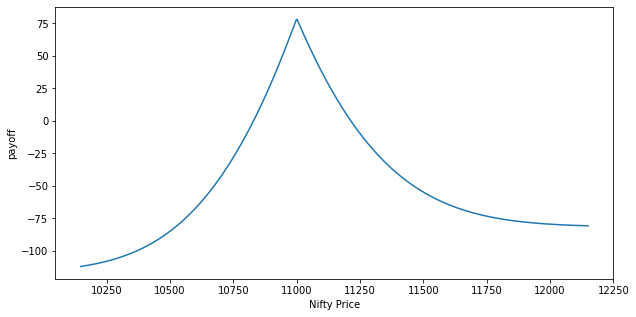

In [7]:
df['payoff'] = df.aug_call_price - df.jul_call_price - setup_cost
plt.figure(figsize=(10, 5))
plt.ylabel("payoff")
plt.xlabel("Nifty Price")
plt.plot(sT, df.payoff)
plt.show()

Graph Interpretation:

Max. Profit: When the Nifty price (on expiry of front-month) is at the strike price of INR 11000. It decreases when we move in either direction away from the Strike Price.

Max. Loss: When the option moves deep ITM (In-The-Money) or deep OTM (Out-of-The-Money).